In [3]:
import sys
sys.path.insert(0,'../src')
sys.path.insert(0,'../data')
sys.path.insert(0,'../upload_data')
sys.path.insert(0,'../config')
sys.path.insert(0,'..')
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import etl
import json
import cleaning
import datetime

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%reload_ext autoreload

In [6]:
census_fp = '../upload_data/sd_population.csv'
census =  pd.read_csv(census_fp)

In [7]:
areas = gpd.read_file('http://seshat.datasd.org/sde/pd/pd_beats_datasd.zip')

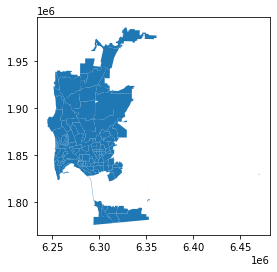

In [8]:
areas.plot()

In [9]:
areas = areas.drop(['objectid', 'name'],axis = 1)
areas

,beat,div,serv,geometry
0,935,9,930,"MULTIPOLYGON (((6268975.465 1931147.469, 62689..."
1,0,0,0,"MULTIPOLYGON (((6261648.576 1836846.672, 62616..."
2,511,5,510,"MULTIPOLYGON (((6261640.429 1836823.561, 62616..."
3,722,7,720,"POLYGON ((6302781.000 1793246.001, 6302905.000..."
4,314,3,310,"POLYGON ((6284667.652 1874418.895, 6284694.392..."
...,...,...,...,...
135,243,2,240,"POLYGON ((6295777.084 1908435.558, 6295790.126..."
136,937,9,930,"POLYGON ((6295209.132 1952772.422, 6295208.647..."
137,936,9,930,"POLYGON ((6287497.113 1936631.116, 6287462.453..."
138,233,2,230,"POLYGON ((6306176.245 1943421.146, 6306158.416..."


In [10]:
areas.dtypes

beat           int64
div            int64
serv           int64
geometry    geometry
dtype: object

In [11]:
census

,YEAR,beat,serv,Total,White,Hispanic/Latino/a,Black,N,Asian,U & P,O,Two or More Races
0,2010,111,110,25358,15779,5866,1346,166,3882,147,2379,1659
1,2010,112,110,9785,8018,1247,162,67,680,32,382,444
2,2010,113,110,11966,9442,2340,160,81,660,36,977,610
3,2010,114,110,14870,10251,3715,259,115,1580,66,1773,826
4,2010,115,110,49029,28823,4690,790,90,15554,86,1582,2104
...,...,...,...,...,...,...,...,...,...,...,...,...
120,2010,933,930,6585,5693,360,46,15,525,5,62,239
121,2010,934,930,43817,29950,3206,343,68,10994,36,620,1806
122,2010,935,930,4836,3446,404,54,10,1038,3,57,228
123,2010,936,930,4163,2390,476,121,5,1268,7,151,221


In [9]:
census[census['Hispanic'] == 0]

,YEAR,beat,serv,Total,White,Hispanic,Black,N,Asian,U & P,O,Two or More Races
119,2010,932,930,4,1,0,1,0,0,0,2,0


In [12]:
pappp = '../data/raw/STOPS_2018-2019.csv'
test = cleaning.clean_2018_2019(pappp)
test

,stop_id,stop_cause,beat,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,2443,Reasonable Suspicion,122,120,White,Male,25,2018-07-01,00:01:37,Y,N,NaN,N,N
1,2444,Traffic Violation,121,120,White,Male,25,2018-07-01,00:03:34,N,N,NaN,N,N
2,2447,Reasonable Suspicion,822,820,Hispanic/Latino/a,Male,30,2018-07-01,00:05:43,N,N,NaN,N,N
3,2448,Traffic Violation,614,610,White,Male,23,2018-07-01,00:19:06,N,N,NaN,N,N
4,2449,Reasonable Suspicion,115,110,White,Male,25,2018-07-01,00:03:00,Y,Y,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241285,255143,Traffic Violation,511,510,Hispanic/Latino/a,Male,19,2019-12-31,11:57:00,N,N,NaN,N,N
241286,255256,Traffic Violation,523,520,Middle Eastern or South Asian,Male,58,2019-12-31,22:42:00,N,N,NaN,N,N
241287,255267,Reasonable Suspicion,523,520,Asian,Male,35,2019-12-31,23:59:37,Y,N,NaN,N,N
241288,255272,Reasonable Suspicion,523,520,Asian,Male,40,2019-12-31,22:20:32,Y,N,NaN,N,N


In [1]:
def div_op(row, race):
    try:
        return row['count']/row[race]
    except:
        return 0
    
def make_proportion(df,race,start_date,end_date):
    sub1 = census[['beat','serv',race]]
    sub2 = make_counts(df,race,start_date,end_date)
    combin = census.merge(sub2, left_on='beat',right_index = True, how = 'outer')
    combin['prop'] = combin.apply(lambda x: div_op(x, race),axis=1)
    return combin[['beat','serv',race,'count', 'prop']]

def make_merged():
    census_fp = '../upload_data/sd_population.csv'
    census =  pd.read_csv(census_fp)
    areas = gpd.read_file('http://seshat.datasd.org/sde/pd/pd_beats_datasd.zip')
    areas = areas.drop(['objectid', 'name'],axis = 1)
    for race in ['White','Asian', 'Black','Hispanic/Latino/a']:
        heat = areas.merge(make_prop(race), on=['beat'],how = 'outer')
    heat = heat.dropna()
    return heat

def make_counts(df,race,start_date,end_date):
    df = df[df.subject_race == race]
    df['date_stop'] = pd.to_datetime(df.date_stop)
    df = df[(df['date_stop'] >= start_date) & (df['date_stop'] <= end_date)].groupby('beat').agg('count')
    return pd.DataFrame(df.stop_id).rename(columns={'stop_id':'count'})

In [142]:
census[['serv','beat','Asian']]

,serv,beat,Asian
0,110,111,3882
1,110,112,680
2,110,113,660
3,110,114,1580
4,110,115,15554
...,...,...,...
120,930,933,525
121,930,934,10994
122,930,935,1038
123,930,936,1268


In [13]:
areas = gpd.read_file('http://seshat.datasd.org/sde/pd/pd_beats_datasd.zip')
areas = areas.drop(['objectid', 'name'],axis = 1)

In [14]:
dfd = make_proportion(test,'Asian','2018-07-01','2018-10-15')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
ggg = areas.merge(dfd, on=['beat'],how = 'outer').dropna()

In [ ]:
heat = areas.merge(census, on=['beat','serv'],how = 'outer')

In [10]:
heat

,beat,div,serv,geometry,YEAR,Total,White,Hispanic,Black,N,Asian,U & P,O,Two or More Races
0,935,9,930,"MULTIPOLYGON (((6268975.465 1931147.469, 62689...",2010.0,4836.0,3446.0,404.0,54.0,10.0,1038.0,3.0,57.0,228.0
1,0,0,0,"MULTIPOLYGON (((6261648.576 1836846.672, 62616...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,511,5,510,"MULTIPOLYGON (((6261640.429 1836823.561, 62616...",2010.0,16576.0,9186.0,5778.0,2734.0,238.0,907.0,96.0,2525.0,890.0
3,511,5,510,"POLYGON ((6283949.000 1837581.000, 6284299.000...",2010.0,16576.0,9186.0,5778.0,2734.0,238.0,907.0,96.0,2525.0,890.0
4,722,7,720,"POLYGON ((6302781.000 1793246.001, 6302905.000...",2010.0,15965.0,7705.0,11429.0,657.0,139.0,2150.0,80.0,4445.0,789.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,243,2,240,"POLYGON ((6295777.084 1908435.558, 6295790.126...",2010.0,5217.0,3697.0,1049.0,505.0,63.0,245.0,34.0,323.0,350.0
136,937,9,930,"POLYGON ((6295209.132 1952772.422, 6295208.647...",2010.0,6653.0,4561.0,649.0,218.0,13.0,1231.0,11.0,181.0,438.0
137,936,9,930,"POLYGON ((6287497.113 1936631.116, 6287462.453...",2010.0,4163.0,2390.0,476.0,121.0,5.0,1268.0,7.0,151.0,221.0
138,233,2,230,"POLYGON ((6306176.245 1943421.146, 6306158.416...",2010.0,46380.0,27295.0,4460.0,1144.0,149.0,13723.0,138.0,1168.0,2763.0


In [11]:
heat = heat.dropna()
heat

,beat,div,serv,geometry,YEAR,Total,White,Hispanic,Black,N,Asian,U & P,O,Two or More Races
0,935,9,930,"MULTIPOLYGON (((6268975.465 1931147.469, 62689...",2010.0,4836.0,3446.0,404.0,54.0,10.0,1038.0,3.0,57.0,228.0
2,511,5,510,"MULTIPOLYGON (((6261640.429 1836823.561, 62616...",2010.0,16576.0,9186.0,5778.0,2734.0,238.0,907.0,96.0,2525.0,890.0
3,511,5,510,"POLYGON ((6283949.000 1837581.000, 6284299.000...",2010.0,16576.0,9186.0,5778.0,2734.0,238.0,907.0,96.0,2525.0,890.0
4,722,7,720,"POLYGON ((6302781.000 1793246.001, 6302905.000...",2010.0,15965.0,7705.0,11429.0,657.0,139.0,2150.0,80.0,4445.0,789.0
5,314,3,310,"POLYGON ((6284667.652 1874418.895, 6284694.392...",2010.0,5184.0,3223.0,1199.0,502.0,57.0,663.0,36.0,340.0,363.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,243,2,240,"POLYGON ((6295777.084 1908435.558, 6295790.126...",2010.0,5217.0,3697.0,1049.0,505.0,63.0,245.0,34.0,323.0,350.0
136,937,9,930,"POLYGON ((6295209.132 1952772.422, 6295208.647...",2010.0,6653.0,4561.0,649.0,218.0,13.0,1231.0,11.0,181.0,438.0
137,936,9,930,"POLYGON ((6287497.113 1936631.116, 6287462.453...",2010.0,4163.0,2390.0,476.0,121.0,5.0,1268.0,7.0,151.0,221.0
138,233,2,230,"POLYGON ((6306176.245 1943421.146, 6306158.416...",2010.0,46380.0,27295.0,4460.0,1144.0,149.0,13723.0,138.0,1168.0,2763.0


In [156]:
ggg.

,beat,div,serv_x,geometry,serv_y,Asian,count,prop
0,935,9,930,"MULTIPOLYGON (((6268975.465 1931147.469, 62689...",930.0,1038.0,6.0,0.005780
2,511,5,510,"MULTIPOLYGON (((6261640.429 1836823.561, 62616...",510.0,907.0,9.0,0.009923
3,511,5,510,"POLYGON ((6283949.000 1837581.000, 6284299.000...",510.0,907.0,9.0,0.009923
4,722,7,720,"POLYGON ((6302781.000 1793246.001, 6302905.000...",720.0,2150.0,12.0,0.005581
5,314,3,310,"POLYGON ((6284667.652 1874418.895, 6284694.392...",310.0,663.0,4.0,0.006033
...,...,...,...,...,...,...,...,...
133,312,3,310,"POLYGON ((6329983.163 1898909.760, 6329939.123...",310.0,2849.0,7.0,0.002457
135,243,2,240,"POLYGON ((6295777.084 1908435.558, 6295790.126...",240.0,245.0,19.0,0.077551
136,937,9,930,"POLYGON ((6295209.132 1952772.422, 6295208.647...",930.0,1231.0,15.0,0.012185
137,936,9,930,"POLYGON ((6287497.113 1936631.116, 6287462.453...",930.0,1268.0,2.0,0.001577


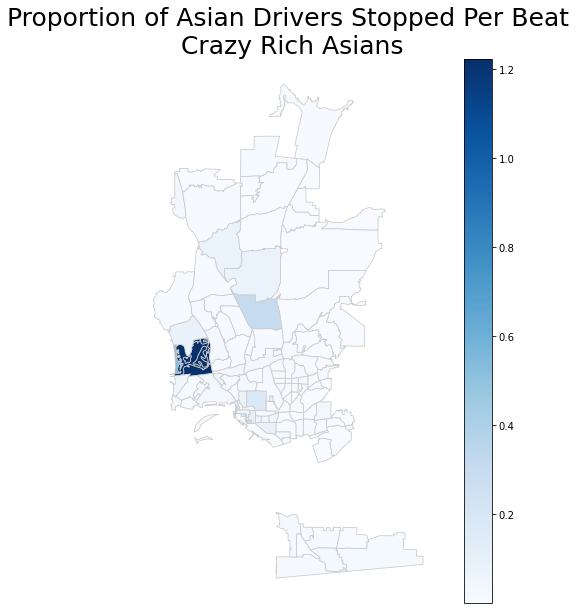

In [16]:
variable = 'Asian'
vmin, vmax = 0, 40000
fig, ax = plt.subplots(1, figsize=(10,10))
ax.axis('off')
ax.set_title('Proportion of Asian Drivers Stopped Per Beat\n Crazy Rich Asians', fontdict={'fontsize':'25','fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=ggg.prop.min(), vmax=ggg.prop.max()))
fig.colorbar(sm)
ggg.plot(column='prop', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

In [13]:
def population_heat(table, race):
    vmin, vmax = 0, roundup(table[race].max())
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.axis('off')
    ax.set_title('# of {r} per each Region'.format(r = race), fontdict={'fontsize':'25','fontweight' : '3'})
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    fig.colorbar(sm)
    table.plot(column=race, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

In [14]:
def make_merged():
    census_fp = '../upload_data/sd_population.csv'
    census =  pd.read_csv(census_fp)
    areas = gpd.read_file('http://seshat.datasd.org/sde/pd/pd_beats_datasd.zip')
    areas = areas.drop(['objectid', 'name'],axis = 1)
    heat = areas.merge(census, on=['beat','serv'],how = 'outer')
    heat = heat.dropna()
    return heat

In [15]:
def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100

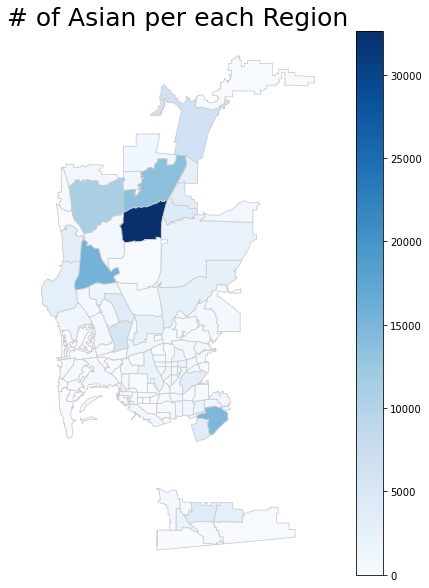

In [20]:
population_heat(heat,'Asian')